**Đề tài:** Nhận dạng chứng cứ cho phân tích cảm xúc dựa trên khía cạnh tiếng Việt. \\
**GVHD:** Nguyễn Lưu Thùy Ngân, Nguyễn Văn Kiệt, Nguyễn Đức Vũ, Lưu Thanh Sơn, Huỳnh Văn Tín, Nguyễn Thành Luân. \\
**Sinh viên thực hiện:** Trần Triệu Vũ, Phạm Đức Thể, Nguyễn Văn Hữu Nghĩa. \\
**Các pre-trained sử dụng:**
- [PhoW2V(syllable-300d)](https://drive.google.com/file/d/1R8lRuZgVtm8GUz2PHtCAQfoaaxwYrQ9o/view?usp=sharing)
- [cc.vi.300.vec](https://drive.google.com/file/d/1RZDd0saERsS_QVA28PU7OZx2NaYHrmlN/view?usp=sharing)
- [wiki.vi.vec](https://drive.google.com/file/d/1GX1LLJ7VEKLkPinjUf9sJXXtr05LVRi1/view?usp=sharing)

# Chuẩn bị dữ liệu

## Check GPU

In [ ]:
!nvidia-smi

Mon Dec 20 06:57:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10968679798073792802
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13376968029468823147
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

## Cài đặt thư viện bổ sung và kết nối drive

In [ ]:
%%capture
!pip install keras-crf
!pip install seqeval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU, Concatenate
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional, Dropout
from keras.initializers import Constant
from keras_crf import CRFModel
from seqeval.metrics import classification_report
from keras.utils.vis_utils import plot_model

## Load data

In [ ]:
def load_data_and_labels(filename, encoding='utf-8'): 
  sents, labels = [], [] 
  words, tags = [], [] 
  with open(filename, encoding=encoding) as f: 
    for line in f: 
      try: 
        line = line.strip() 
        if line: 
          word, tag = line.split(" ") 
          words.append(word) 
          tags.append(tag) 
        else: 
          sents.append(words) 
          labels.append(tags) 
          words, tags = [], [] 
      except Exception as e: 
        pass
  return sents, labels 

In [ ]:
train_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/polarity/train.txt') 
dev_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/polarity/dev.txt')  
test_set = load_data_and_labels('/content/drive/MyDrive/DS310_DOAN/polarity/test.txt')

## Lấy words và tags

In [ ]:
words = list(set(np.concatenate((np.concatenate(train_set[0]), np.concatenate(dev_set[0])))))
words.append("UNK")
words.append("ENDPAD")
tags = list(set(np.concatenate((np.concatenate(train_set[1]), np.concatenate(dev_set[1])))))

num_words = len(words)
num_tags = len(tags)

## Tạo word2idx và tag2idx

In [ ]:
word2idx = {w:i for i,w in enumerate(words)} 
tag2idx = {t:i for i,t in enumerate(tags)}

## Encoding

In [ ]:
max_len = 100
def encoding(data): 
  X = [[word2idx.get(w, num_words-2) for w in t] for t in data[0]] 
  X = pad_sequences(maxlen = max_len, sequences = X, 
                    padding = "post", value = num_words-1) 

  y = [[tag2idx[w] for w in s] for s in data[1]] 
  y = pad_sequences(maxlen=max_len, sequences=y, 
                    padding="post", value=tag2idx["O"])

  return X, y 
 
x_train, y_train = encoding(train_set) 
x_dev, y_dev = encoding(dev_set) 
x_test, y_test = encoding(test_set) 

# Không dử dụng pre-trained embedding

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
input_word = Input(shape=(max_len,), dtype="float64")

# embedding
emb = Embedding(input_dim=num_words, output_dim=300,
                    input_length=max_len)(input_word)

# model
model = SpatialDropout1D(0.33)(emb)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout = 0.33))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout = 0.33))(model)
model = SpatialDropout1D(0.33)(model)
out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
model = Model(input_word, out)
model = CRFModel(model, num_tags)

# setting and summary
opt = optimizers.Nadam(1e-2)
model.compile(optimizer=opt, metrics=['acc'])
model.summary()

Model: "crf_model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 300)     3811500     ['input_4[0][0]']                
                                                                                                  
 spatial_dropout1d_6 (SpatialDr  (None, 100, 300)    0           ['embedding_3[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 100, 200)    320800      ['spatial_dropout1d_6[0

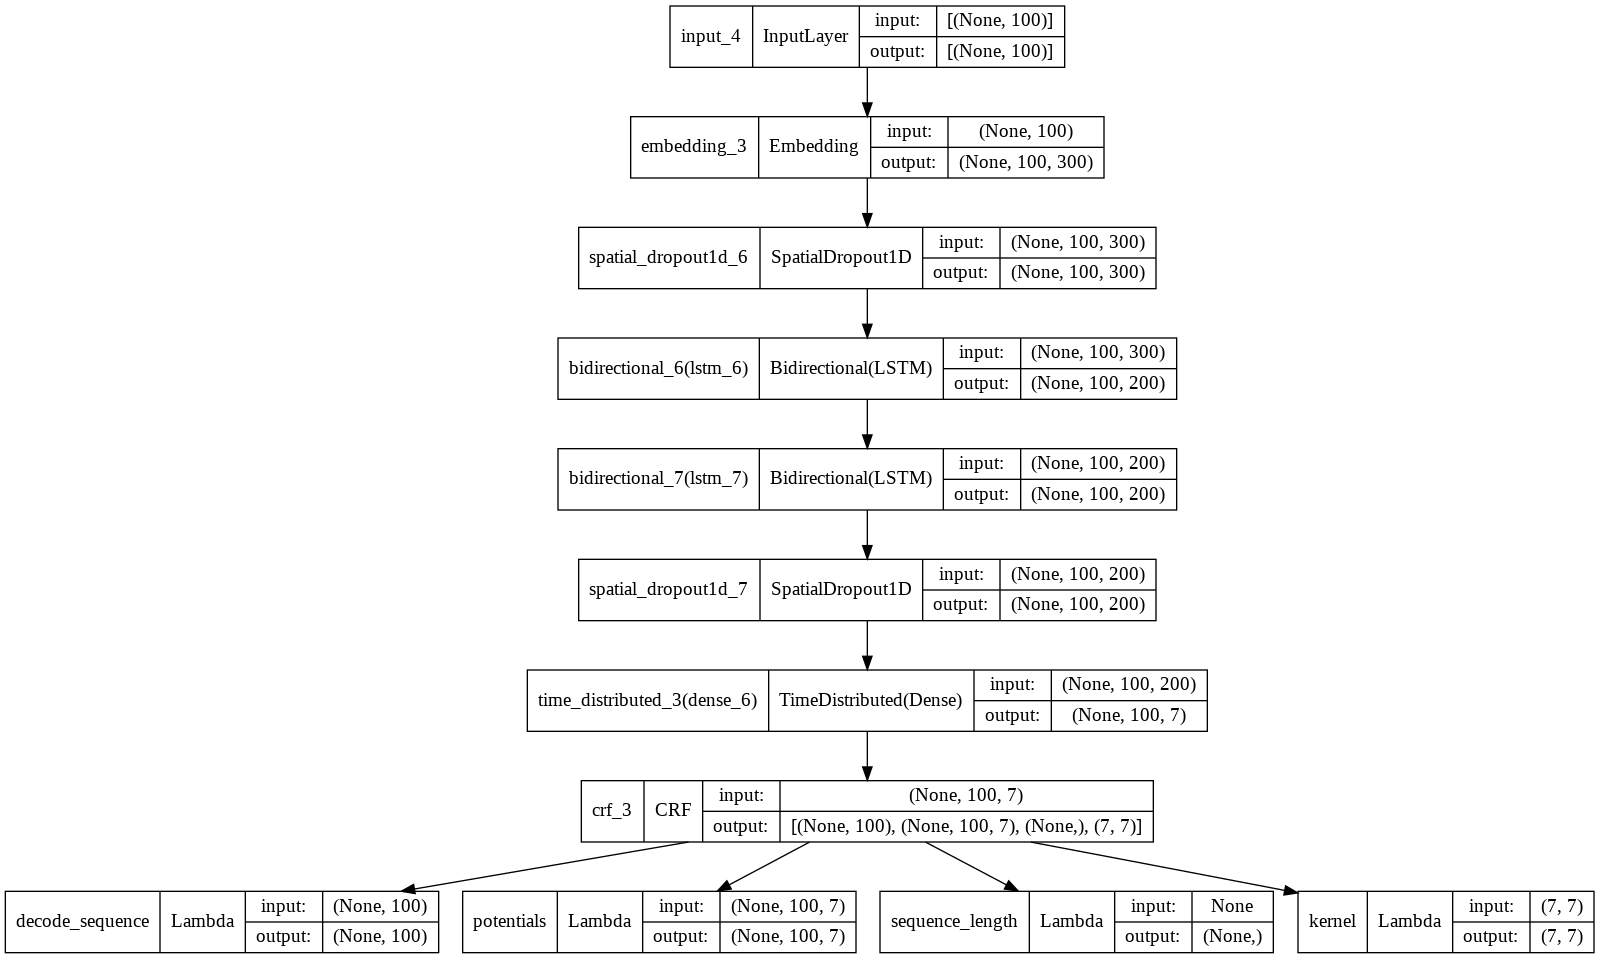

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 44s 912ms/step - decode_sequence_acc: 0.7699 - loss: 52.7556 - val_decode_sequence_acc: 0.8041 - val_loss: 34.8856
Epoch 2/30
26/26 [==============================] - 13s 491ms/step - decode_sequence_acc: 0.8411 - loss: 29.7907 - val_decode_sequence_acc: 0.8533 - val_loss: 25.7557
Epoch 3/30
26/26 [==============================] - 9s 330ms/step - decode_sequence_acc: 0.8715 - loss: 21.2369 - val_decode_sequence_acc: 0.8612 - val_loss: 19.9853
Epoch 4/30
26/26 [==============================] - 8s 327ms/step - decode_sequence_acc: 0.8840 - loss: 16.3009 - val_decode_sequence_acc: 0.8615 - val_loss: 17.4341
Epoch 5/30
26/26 [==============================] - 9s 332ms/step - decode_sequence_acc: 0.8912 - loss: 13.1908 - val_decode_sequence_acc: 0.8655 - val_loss: 16.4243
Epoch 6/30
26/26 [==============================] - 8s 326ms/step - decode_sequence_acc: 0.8966 - loss: 11.1789 - val_decode_sequence_acc: 0.8667 - val_loss: 14.0314
Ep

## Đánh giá mô hình

In [ ]:
def print_report():
  y_tr = y_test
  y_pr = model.predict(np.array(x_test))
  y_pr = y_pr[0]

  Y_tr = []
  Y_pr = []

  for i, j in zip(range(len(y_tr)), range(len(y_pr))):
    true = []
    pred = []
    for k in range(len(y_tr[i])):
      true.append(tags[y_tr[i][k]])
      pred.append(tags[y_pr[j][k]])
    Y_tr.append(true)
    Y_pr.append(pred)

  print(classification_report(Y_tr, Y_pr, digits =4,))

In [ ]:
print_report()

              precision    recall  f1-score   support

    NEGATIVE     0.2975    0.3086    0.3030      1944
     NEUTRAL     0.2330    0.2222    0.2275       369
    POSITIVE     0.5526    0.5237    0.5377      3754

   micro avg     0.4468    0.4365    0.4416      6067
   macro avg     0.3610    0.3515    0.3561      6067
weighted avg     0.4514    0.4365    0.4436      6067



In [ ]:
def predict(i):
  y_pred = model.predict(np.array([x_test[i]]))
  y_pred = y_pred[0]
  y_true = y_test[i]
  print("{:20}{:20}\t {}\n".format("Word", "True", "Pred"))
  print("-" *30)
  for w, true, pred in zip(x_test[i], y_true, y_pred[0]):
      print("{:20}{:20}\t{}".format(words[w], tags[true], tags[pred]))

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-POSITIVE
thấy                B-POSITIVE          	I-POSITIVE
mẫu                 I-POSITIVE          	I-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	B-POSITIVE
ứng                 I-POSITIVE          	I-POSITIVE
mượt                I-POSITIVE          	I-POSITIVE
được                B-POSITIVE          	I-POSITIVE
em                  I-POSITIVE          	I-POSITIVE
nhân                I-POSITIVE          	O
viên                I-POSITIVE          	O
ĐMX                 I-POSITIVE          	O
tư                  I-POSITIVE          	O
vấn  

# Sử dụng pre-trained PhoW2V

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/word2vec_vi_syllables_300dims.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix1 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix1[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
def model_BiLSTM_CRF(embedding_matrix):
  input_word = Input(shape=(max_len,), dtype="float64")

  # syllabel embedding
  syl_emb = Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant([embedding_matrix]),
                    input_length=max_len, trainable=True)(input_word)

  # model
  model = SpatialDropout1D(0.33)(syl_emb)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = SpatialDropout1D(0.33)(model)
  out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
  model = Model(input_word, out)
  model = CRFModel(model, num_tags)

  # setting and summary
  opt = optimizers.Nadam(1e-2)
  model.compile(optimizer=opt, metrics=['acc'])
  return model

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix1)
model.summary()

Model: "crf_model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 300)     3811500     ['input_5[0][0]']                
                                                                                                  
 spatial_dropout1d_8 (SpatialDr  (None, 100, 300)    0           ['embedding_4[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 100, 200)    320800      ['spatial_dropout1d_8[0

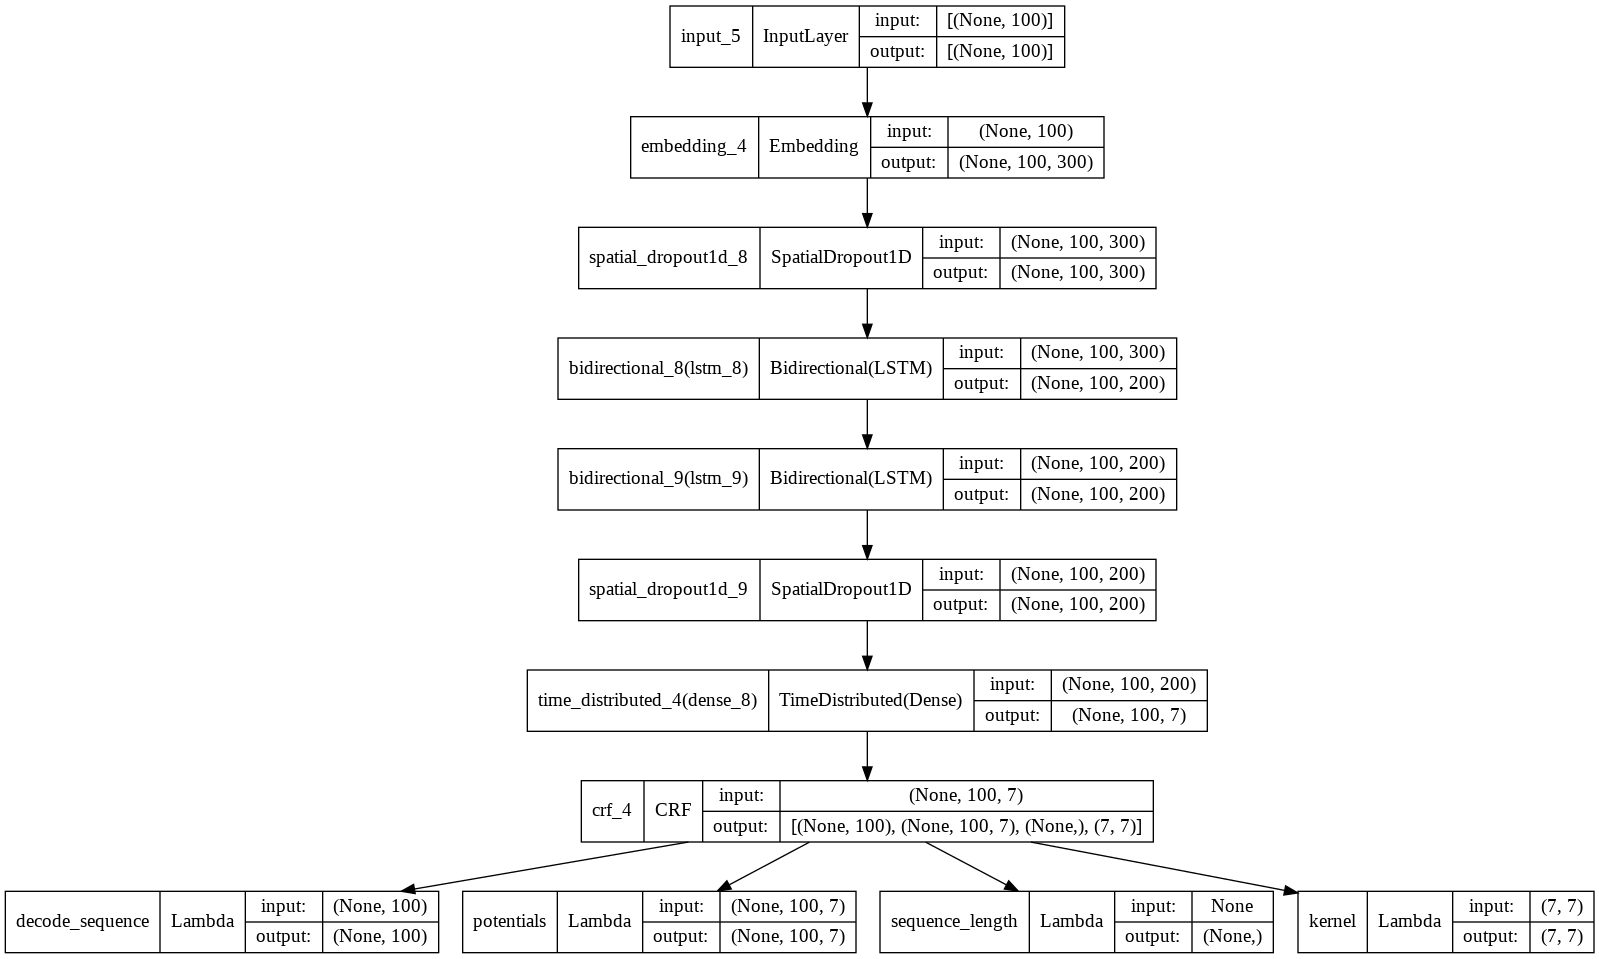

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 22s 421ms/step - decode_sequence_acc: 0.7536 - loss: 76.2267 - val_decode_sequence_acc: 0.8176 - val_loss: 40.8534
Epoch 2/30
26/26 [==============================] - 9s 329ms/step - decode_sequence_acc: 0.8248 - loss: 38.1082 - val_decode_sequence_acc: 0.8492 - val_loss: 29.0193
Epoch 3/30
26/26 [==============================] - 9s 328ms/step - decode_sequence_acc: 0.8596 - loss: 27.5483 - val_decode_sequence_acc: 0.8485 - val_loss: 24.1241
Epoch 4/30
26/26 [==============================] - 8s 326ms/step - decode_sequence_acc: 0.8734 - loss: 21.5253 - val_decode_sequence_acc: 0.8672 - val_loss: 19.4602
Epoch 5/30
26/26 [==============================] - 8s 323ms/step - decode_sequence_acc: 0.8824 - loss: 17.7000 - val_decode_sequence_acc: 0.8703 - val_loss: 17.6687
Epoch 6/30
26/26 [==============================] - 9s 331ms/step - decode_sequence_acc: 0.8871 - loss: 15.1204 - val_decode_sequence_acc: 0.8677 - val_loss: 16.2175
Epo

## Đánh giá mô hình

In [ ]:
print_report()

              precision    recall  f1-score   support

    NEGATIVE     0.2968    0.3596    0.3252      1944
     NEUTRAL     0.2792    0.2331    0.2541       369
    POSITIVE     0.5216    0.5978    0.5571      3754

   micro avg     0.4349    0.4993    0.4649      6067
   macro avg     0.3659    0.3968    0.3788      6067
weighted avg     0.4348    0.4993    0.4644      6067



In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-POSITIVE
thấy                B-POSITIVE          	I-POSITIVE
mẫu                 I-POSITIVE          	I-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	B-POSITIVE
ứng                 I-POSITIVE          	I-POSITIVE
mượt                I-POSITIVE          	I-POSITIVE
được                B-POSITIVE          	O
em                  I-POSITIVE          	O
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I-POSITIVE         

# Sử dụng pre-trained cc.vi.300.vec

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/cc.vi.300.vec')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix2 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix2[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix2[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện BiLSTM-CRF

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix2)
model.summary()

Model: "crf_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 300)     3811500     ['input_6[0][0]']                
                                                                                                  
 spatial_dropout1d_10 (SpatialD  (None, 100, 300)    0           ['embedding_5[0][0]']            
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 100, 200)    320800      ['spatial_dropout1d_10[

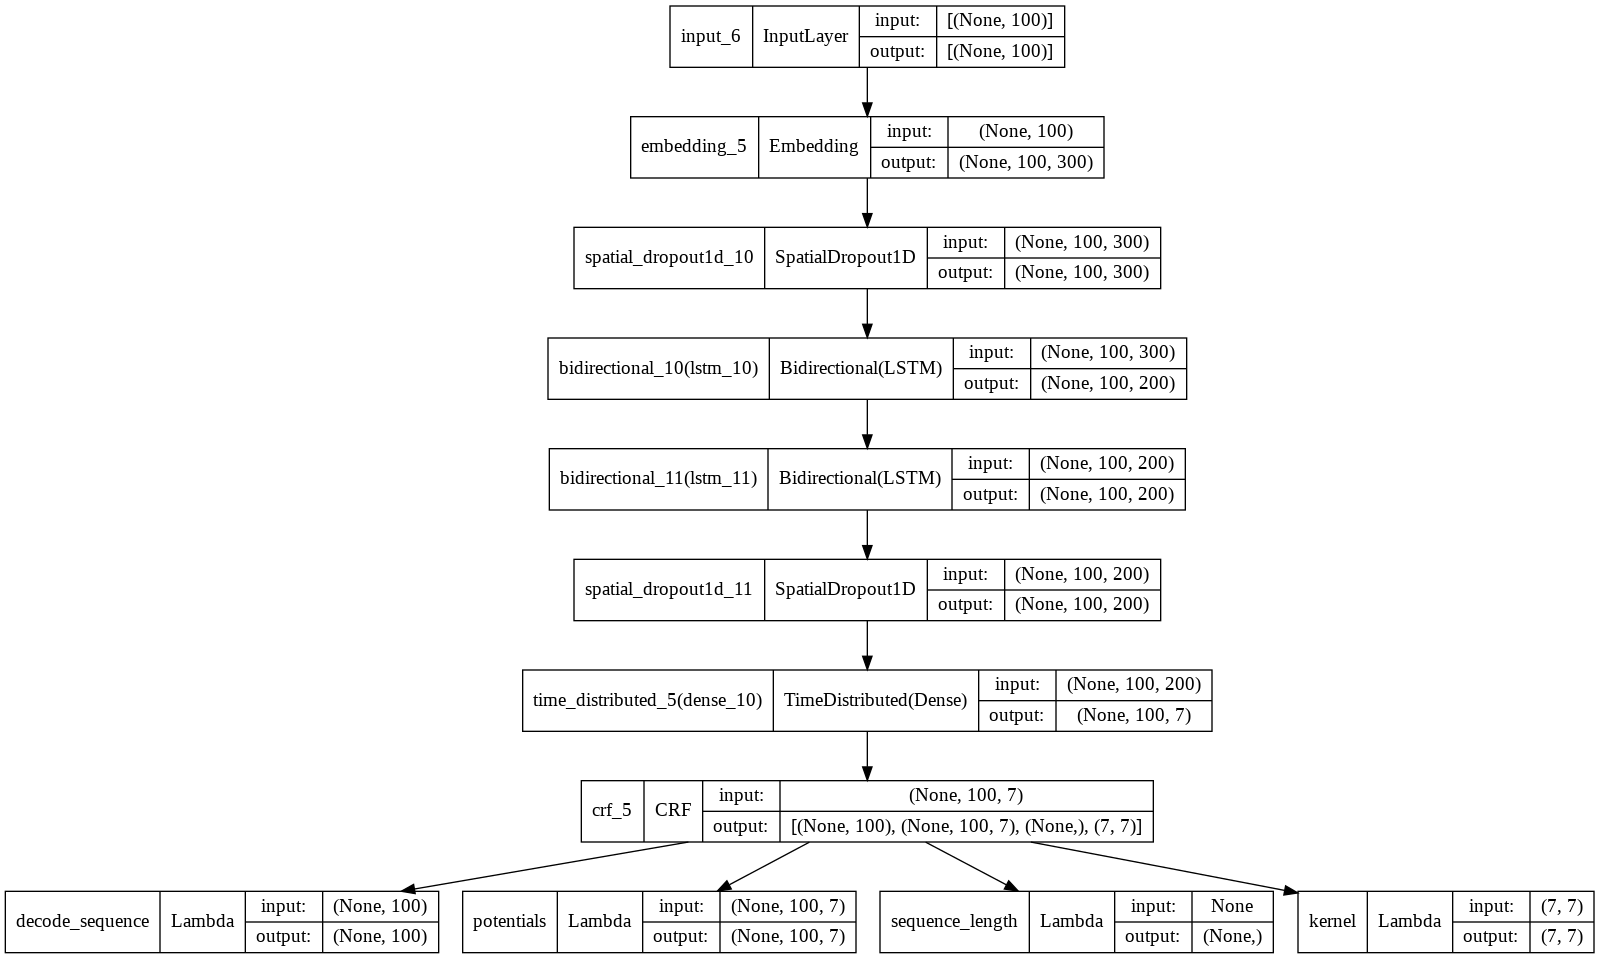

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 24s 460ms/step - decode_sequence_acc: 0.7365 - loss: 86.8996 - val_decode_sequence_acc: 0.8107 - val_loss: 48.9365
Epoch 2/30
26/26 [==============================] - 9s 343ms/step - decode_sequence_acc: 0.8126 - loss: 47.2617 - val_decode_sequence_acc: 0.8267 - val_loss: 37.0384
Epoch 3/30
26/26 [==============================] - 9s 338ms/step - decode_sequence_acc: 0.8337 - loss: 35.7134 - val_decode_sequence_acc: 0.8528 - val_loss: 28.8694
Epoch 4/30
26/26 [==============================] - 9s 338ms/step - decode_sequence_acc: 0.8670 - loss: 26.0513 - val_decode_sequence_acc: 0.8663 - val_loss: 23.1959
Epoch 5/30
26/26 [==============================] - 9s 341ms/step - decode_sequence_acc: 0.8812 - loss: 20.5304 - val_decode_sequence_acc: 0.8601 - val_loss: 21.9111
Epoch 6/30
26/26 [==============================] - 9s 338ms/step - decode_sequence_acc: 0.8895 - loss: 16.9320 - val_decode_sequence_acc: 0.8718 - val_loss: 17.9355
Epo

## Đánh giá mô hình

In [ ]:
print_report()

              precision    recall  f1-score   support

    NEGATIVE     0.3153    0.3596    0.3360      1944
     NEUTRAL     0.2181    0.2873    0.2480       369
    POSITIVE     0.5314    0.5988    0.5631      3754

   micro avg     0.4404    0.5032    0.4697      6067
   macro avg     0.3549    0.4152    0.3824      6067
weighted avg     0.4431    0.5032    0.4712      6067



In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-POSITIVE
thấy                B-POSITIVE          	I-POSITIVE
mẫu                 I-POSITIVE          	I-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	B-POSITIVE
ứng                 I-POSITIVE          	I-POSITIVE
mượt                I-POSITIVE          	I-POSITIVE
được                B-POSITIVE          	I-POSITIVE
em                  I-POSITIVE          	I-POSITIVE
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I

# Sử dụng pre-trained wiki.vi.vec

## Load pre-trained và tạo pre-trained matrix

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = 10000

f = open('/content/drive/MyDrive/DS310_DOAN/wiki.vi.vec')
for line in f:
    values = line.split(' ')[:-1]
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix3 = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word2idx.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix3[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix3[i] = np.random.randn(embedding_dim)

## Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = model_BiLSTM_CRF(embedding_matrix3)
model.summary()

Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     3811500     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 100, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 200)     320800      ['spatial_dropout1d[0][0]

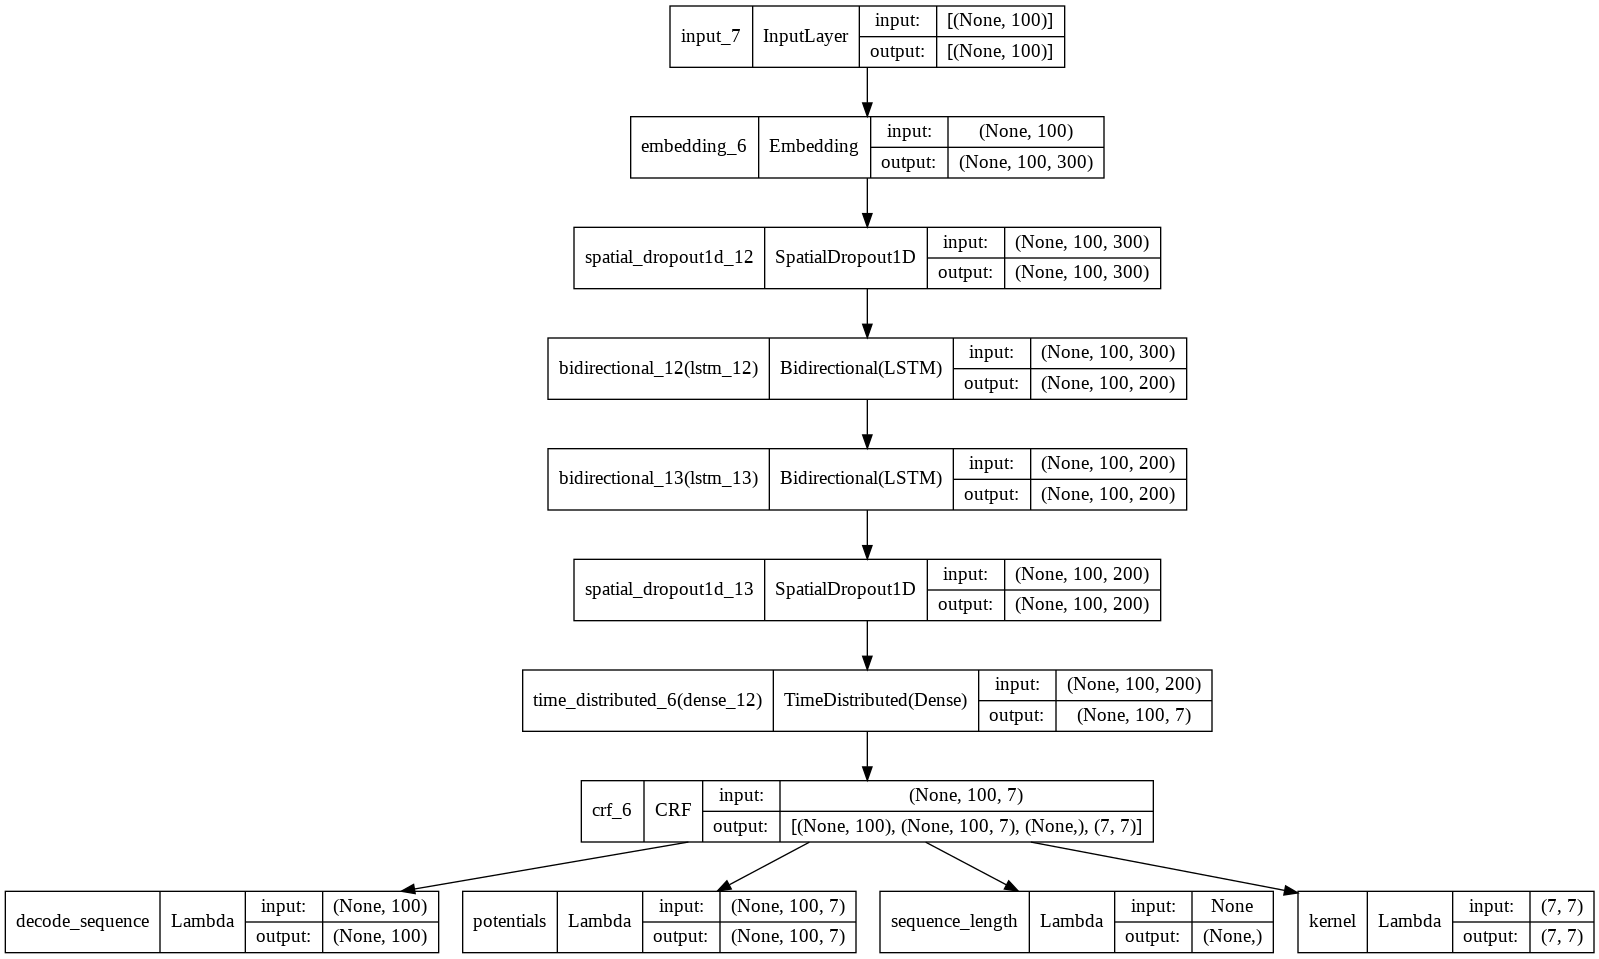

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_dev,y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 30s 573ms/step - decode_sequence_acc: 0.7596 - loss: 72.3597 - val_decode_sequence_acc: 0.8009 - val_loss: 41.7682
Epoch 2/30
26/26 [==============================] - 12s 464ms/step - decode_sequence_acc: 0.8184 - loss: 39.5213 - val_decode_sequence_acc: 0.8475 - val_loss: 27.7707
Epoch 3/30
26/26 [==============================] - 12s 468ms/step - decode_sequence_acc: 0.8527 - loss: 27.3676 - val_decode_sequence_acc: 0.8651 - val_loss: 20.9524
Epoch 4/30
26/26 [==============================] - 12s 464ms/step - decode_sequence_acc: 0.8711 - loss: 21.0050 - val_decode_sequence_acc: 0.8637 - val_loss: 18.0987
Epoch 5/30
26/26 [==============================] - 12s 460ms/step - decode_sequence_acc: 0.8775 - loss: 17.5452 - val_decode_sequence_acc: 0.8678 - val_loss: 15.6972
Epoch 6/30
26/26 [==============================] - 12s 473ms/step - decode_sequence_acc: 0.8848 - loss: 14.5033 - val_decode_sequence_acc: 0.8656 - val_loss: 14.037

## Đánh giá mô hình

In [ ]:
print_report()

              precision    recall  f1-score   support

    NEGATIVE     0.3459    0.3549    0.3503      1944
     NEUTRAL     0.2649    0.2168    0.2385       369
    POSITIVE     0.5430    0.5916    0.5663      3754

   micro avg     0.4683    0.4930    0.4803      6067
   macro avg     0.3846    0.3878    0.3850      6067
weighted avg     0.4629    0.4930    0.4772      6067



In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-POSITIVE
thấy                B-POSITIVE          	I-POSITIVE
mẫu                 I-POSITIVE          	I-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	B-POSITIVE
ứng                 I-POSITIVE          	I-POSITIVE
mượt                I-POSITIVE          	I-POSITIVE
được                B-POSITIVE          	I-POSITIVE
em                  I-POSITIVE          	I-POSITIVE
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I

# Kết hợp với char-LSTM

## Char encode

In [ ]:
max_len_char = 15
chars = set([c for w in words for c in w])
n_chars = len(chars) + 2

In [ ]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [ ]:
def char_encode(data):
  X_char = []
  sent_idx = 0
  for sentence in data:
      sent_seq = []
      for i in range(max_len):
          word_seq = []
          for j in range(max_len_char):
              try:
                  word_seq.append(char2idx.get(data[sent_idx][i][j], char2idx.get('UNK')))
              except:
                  word_seq.append(char2idx.get('PAD'))
          sent_seq.append(word_seq)
      X_char.append(np.array(sent_seq))
      sent_idx += 1
  return X_char

In [ ]:
x_char_train = char_encode(train_set[0])
x_char_dev = char_encode(dev_set[0])
x_char_test = char_encode(test_set[0])

In [ ]:
x_char_train = np.array(x_char_train).reshape((len(x_char_train), max_len, max_len_char))
x_char_dev = np.array(x_char_dev).reshape((len(x_char_dev), max_len, max_len_char))
x_char_test = np.array(x_char_test).reshape((len(x_char_test), max_len, max_len_char))

## Không sử dụng pre-trained embedding

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
# syllabel embedding
input_word = Input(shape=(max_len,), dtype="float64")
syl_emb = Embedding(input_dim=num_words, output_dim=100,
                    input_length=max_len)(input_word)

# character embedding
input_char = Input(shape=(max_len, max_len_char,), dtype="float64")
char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=embedding_dim,
                           input_length=max_len_char))(input_char)
char_emb = Dropout(0.33)(char_emb)
char_emb = TimeDistributed(LSTM(units=100, return_sequences=False, dropout=0.33))(char_emb)
char_emb = SpatialDropout1D(0.33)(char_emb)
char_emb = TimeDistributed(Dense(100, activation="relu"))(char_emb)

# Concatenate
emb = Concatenate()([syl_emb, char_emb])

# model
model = SpatialDropout1D(0.33)(emb)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
model = SpatialDropout1D(0.33)(model)
out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
model = Model([input_word, input_char], out)
model = CRFModel(model, num_tags)

# setting and summary
opt = optimizers.Nadam(2e-2)
model.compile(optimizer=opt, metrics=['acc'])

In [ ]:
model.summary()

Model: "crf_model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_7 (TimeDistri  (None, 100, 15, 300  102000     ['input_9[0][0]']                
 buted)                         )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 100, 15, 300  0           ['time_distributed_7[0][0]']     
                                )                                                                 
                                                                                        

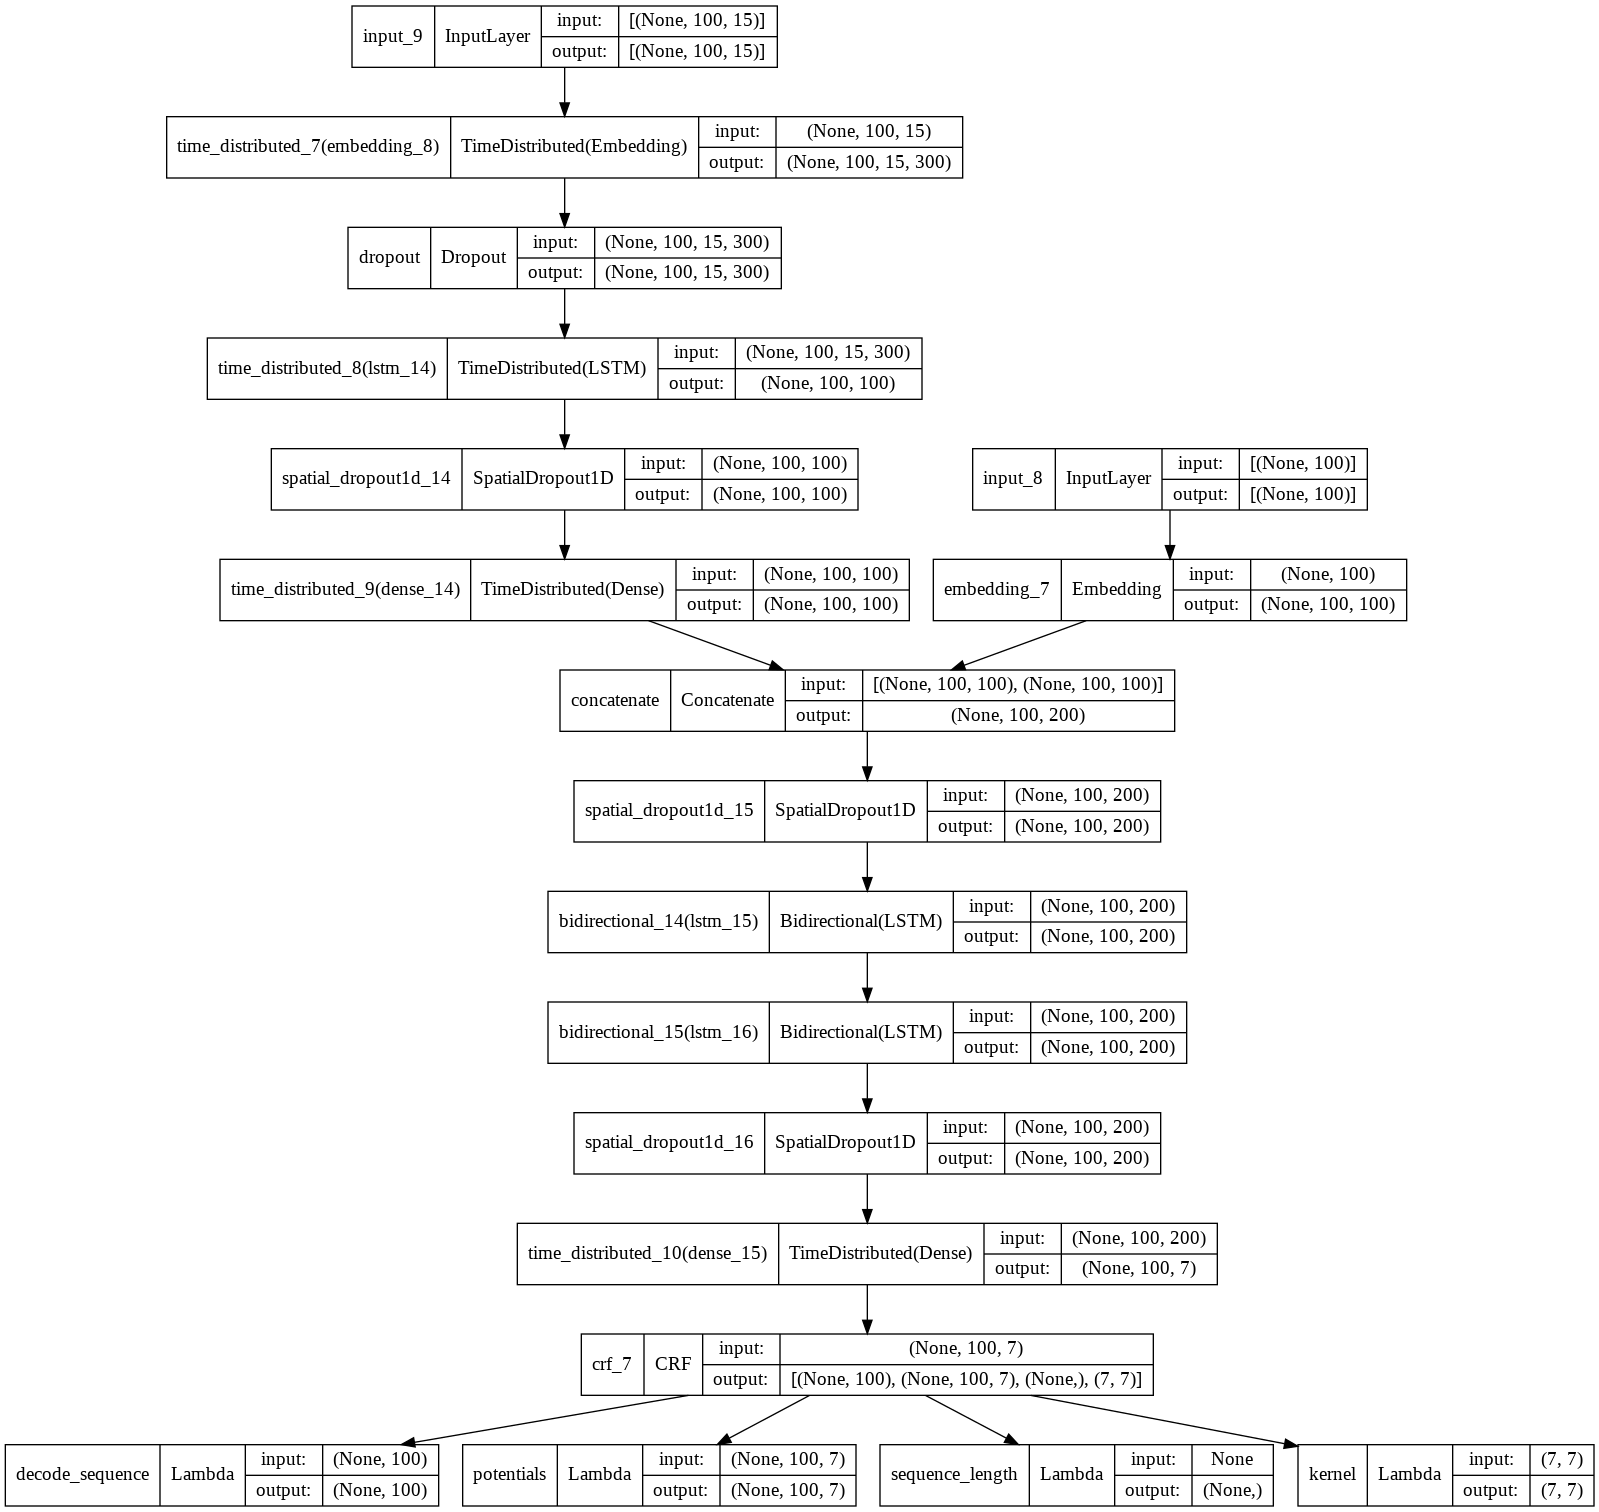

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 32s 639ms/step - decode_sequence_acc: 0.7307 - loss: 76.3830 - val_decode_sequence_acc: 0.7918 - val_loss: 37.7161
Epoch 2/30
26/26 [==============================] - 14s 525ms/step - decode_sequence_acc: 0.8045 - loss: 32.9916 - val_decode_sequence_acc: 0.8115 - val_loss: 25.6929
Epoch 3/30
26/26 [==============================] - 14s 522ms/step - decode_sequence_acc: 0.8246 - loss: 22.7977 - val_decode_sequence_acc: 0.8314 - val_loss: 17.4951
Epoch 4/30
26/26 [==============================] - 14s 521ms/step - decode_sequence_acc: 0.8317 - loss: 17.6149 - val_decode_sequence_acc: 0.8212 - val_loss: 15.8937
Epoch 5/30
26/26 [==============================] - 13s 517ms/step - decode_sequence_acc: 0.8342 - loss: 14.5738 - val_decode_sequence_acc: 0.8370 - val_loss: 12.5406
Epoch 6/30
26/26 [==============================] - 14s 530ms/step - decode_sequence_acc: 0.8415 - loss: 11.9973 - val_decode_sequence_acc: 0.8362 - val_loss: 11.134

### Đánh giá mô hình

In [ ]:
def cprint_report():
  y_tr = y_test
  y_pr = model.predict([x_test, x_char_test.astype(np.float)])[0]

  Y_tr = []
  Y_pr = []

  for i, j in zip(range(len(y_tr)), range(len(y_pr))):
    true = []
    pred = []
    for k in range(len(y_tr[i])):
      true.append(tags[y_tr[i][k]])
      pred.append(tags[y_pr[j][k]])
    Y_tr.append(true)
    Y_pr.append(pred)

  print(classification_report(Y_tr, Y_pr, digits =4,))

In [ ]:
cprint_report()

              precision    recall  f1-score   support

    NEGATIVE     0.3713    0.3287    0.3487      1944
     NEUTRAL     0.2364    0.2114    0.2232       369
    POSITIVE     0.5531    0.5908    0.5714      3754

   micro avg     0.4842    0.4838    0.4840      6067
   macro avg     0.3869    0.3770    0.3811      6067
weighted avg     0.4756    0.4838    0.4788      6067



In [ ]:
def cpredict(i):
  y_pr = model.predict([x_test, x_char_test.astype(np.float)])[0]
  y_pred = y_pr[i]
  y_true = y_test[i]
  print("{:20}{:20}\t {}\n".format("Word", "True", "Pred"))
  print("-" *30)
  for w, true, pred in zip(x_test[i], y_true, y_pred):
      print("{:20}{:20}\t{}".format(words[w], tags[true], tags[pred]))

In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-POSITIVE          	O
mẫu                 I-POSITIVE          	B-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	O
ứng                 I-POSITIVE          	O
mượt                I-POSITIVE          	O
được                B-POSITIVE          	O
em                  I-POSITIVE          	O
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I-POSITIVE          	I-POSITIVE
vấn                 I-POSITIVE  

## Sử dụng pre-trained PhoW2V

### Xây dựng và huấn luyện mô hình

In [ ]:
# syllabel embedding
def cmodel_BiLSTM_CRF(embedding_matrix):
  input_word = Input(shape=(max_len,), dtype="float64")
  syl_emb = Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant([embedding_matrix]),
                      input_length=max_len, trainable=True)(input_word)

  # character embedding
  input_char = Input(shape=(max_len, max_len_char,), dtype="float64")
  char_emb = TimeDistributed(Embedding(input_dim=n_chars, output_dim=embedding_dim,
                            input_length=max_len_char))(input_char)
  char_emb = Dropout(0.33)(char_emb)
  char_emb = TimeDistributed(LSTM(units=100, return_sequences=False, dropout=0.33))(char_emb)
  char_emb = SpatialDropout1D(0.33)(char_emb)
  char_emb = TimeDistributed(Dense(100, activation="relu"))(char_emb)

  # Concatenate
  emb = Concatenate()([syl_emb, char_emb])

  # model
  model = SpatialDropout1D(0.33)(emb)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.33))(model)
  model = SpatialDropout1D(0.33)(model)
  out = TimeDistributed(Dense(num_tags, activation="LeakyReLU"))(model)
  model = Model([input_word, input_char], out)
  model = CRFModel(model, num_tags)

  # setting and summary
  opt = optimizers.Nadam(2e-2)
  model.compile(optimizer=opt, metrics=['acc'])
  return model

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix1)
model.summary()

Model: "crf_model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_11 (TimeDistr  (None, 100, 15, 300  102000     ['input_11[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 100, 15, 300  0           ['time_distributed_11[0][0]']    
                                )                                                                 
                                                                                        

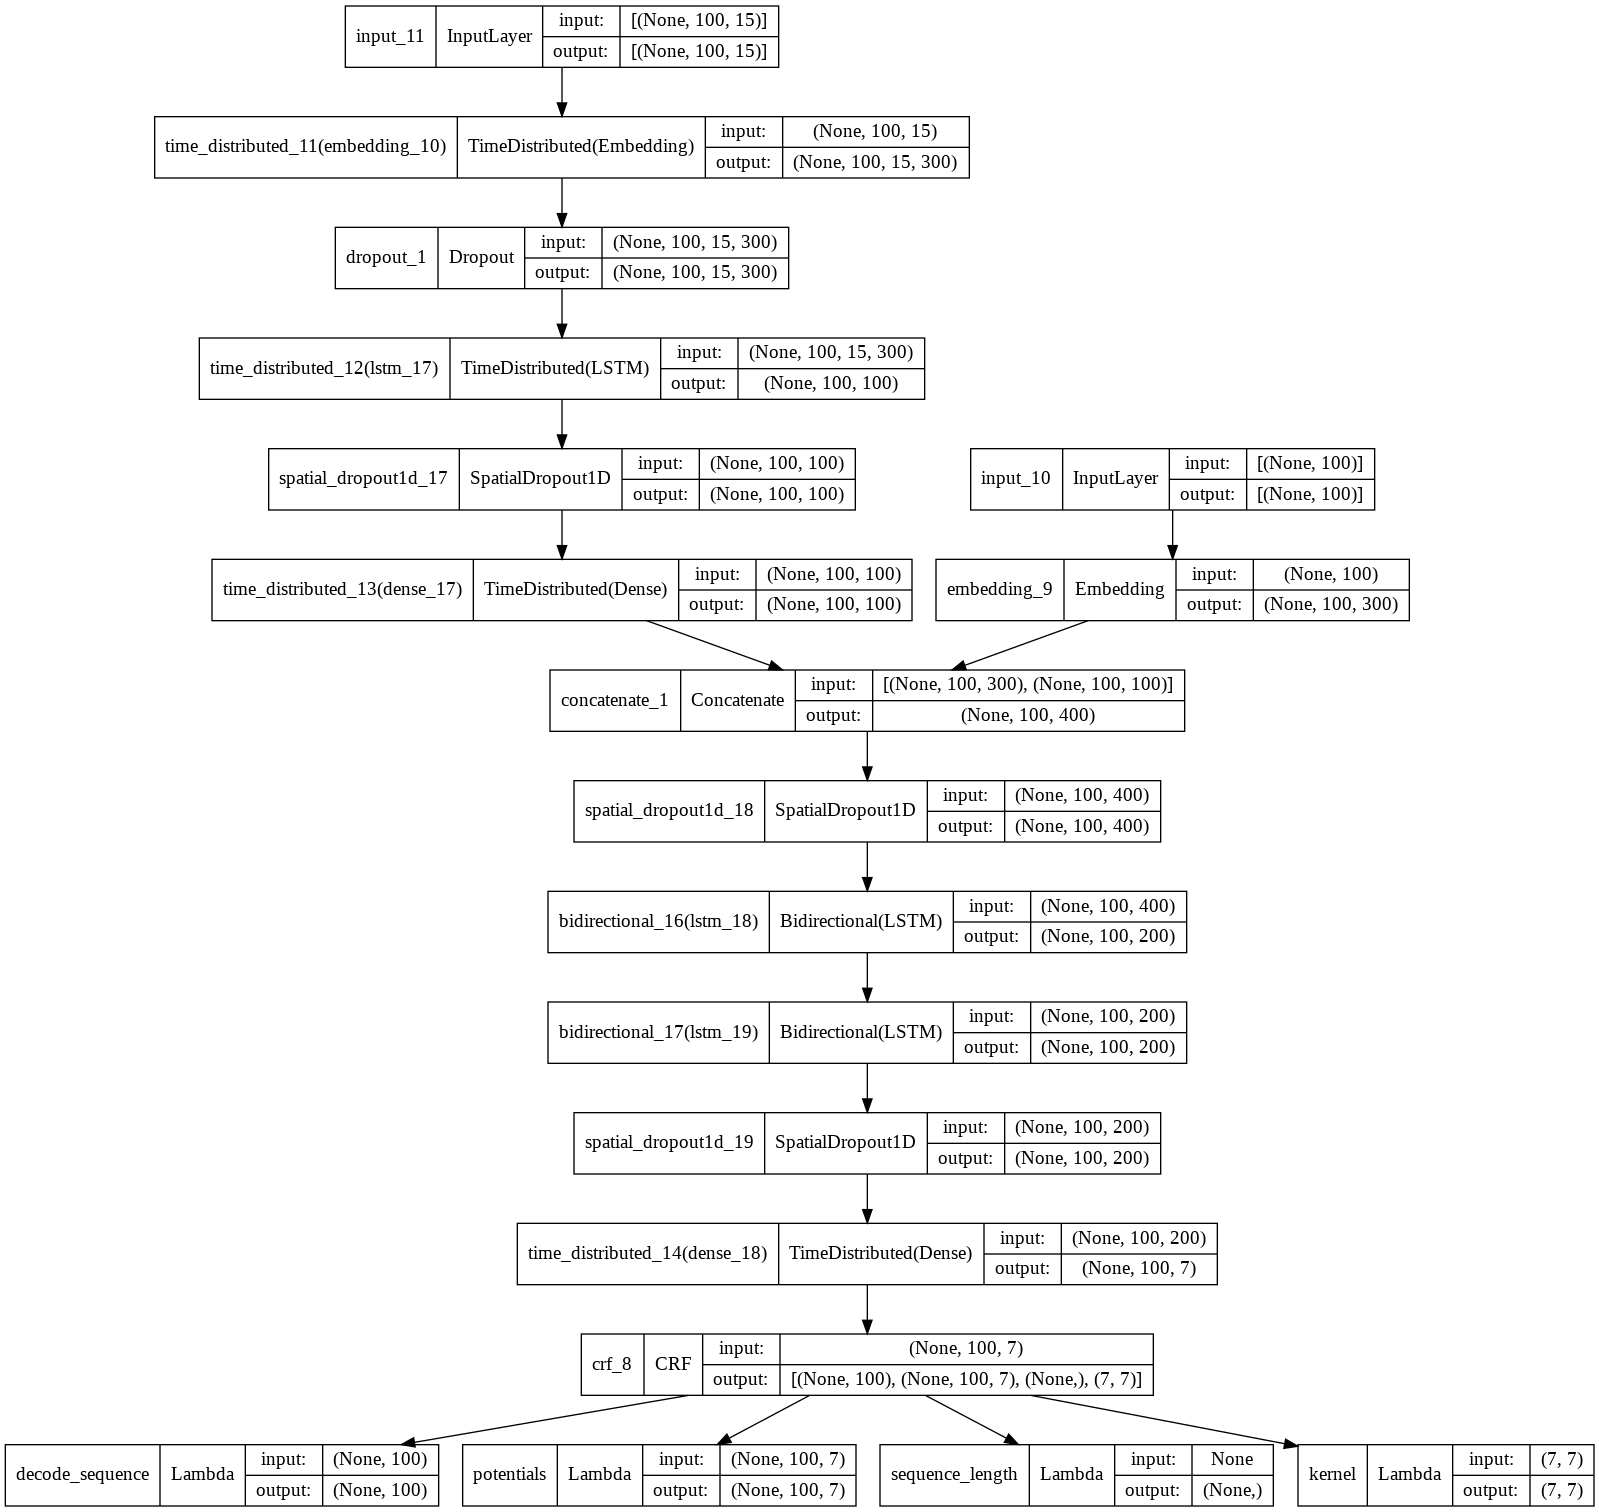

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 40s 967ms/step - decode_sequence_acc: 0.7106 - loss: 78.6283 - val_decode_sequence_acc: 0.7918 - val_loss: 52.5168
Epoch 2/30
26/26 [==============================] - 15s 564ms/step - decode_sequence_acc: 0.7766 - loss: 46.7565 - val_decode_sequence_acc: 0.7918 - val_loss: 38.0965
Epoch 3/30
26/26 [==============================] - 14s 531ms/step - decode_sequence_acc: 0.7518 - loss: 36.3175 - val_decode_sequence_acc: 0.7217 - val_loss: 30.9365
Epoch 4/30
26/26 [==============================] - 14s 534ms/step - decode_sequence_acc: 0.7643 - loss: 28.0746 - val_decode_sequence_acc: 0.7918 - val_loss: 22.1799
Epoch 5/30
26/26 [==============================] - 14s 529ms/step - decode_sequence_acc: 0.7684 - loss: 21.1826 - val_decode_sequence_acc: 0.7586 - val_loss: 18.2360
Epoch 6/30
26/26 [==============================] - 14s 531ms/step - decode_sequence_acc: 0.7702 - loss: 17.0586 - val_decode_sequence_acc: 0.7645 - val_loss: 15.858

### Đánh giá mô hình

In [ ]:
cprint_report()

              precision    recall  f1-score   support

    NEGATIVE     0.3122    0.3426    0.3267      1944
     NEUTRAL     0.3333    0.1789    0.2328       369
    POSITIVE     0.5259    0.5698    0.5470      3754

   micro avg     0.4487    0.4732    0.4606      6067
   macro avg     0.3905    0.3637    0.3688      6067
weighted avg     0.4458    0.4732    0.4573      6067



In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-POSITIVE
thấy                B-POSITIVE          	I-POSITIVE
mẫu                 I-POSITIVE          	I-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	O
ứng                 I-POSITIVE          	O
mượt                I-POSITIVE          	O
được                B-POSITIVE          	O
em                  I-POSITIVE          	O
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I-POSITIVE          	I-POSITIVE
vấn           

## Sử dụng pre-trained cc.vi.300.vec

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix2)
model.summary()

Model: "crf_model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_23 (TimeDistr  (None, 100, 15, 300  102000     ['input_17[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_4 (Dropout)            (None, 100, 15, 300  0           ['time_distributed_23[0][0]']    
                                )                                                                 
                                                                                       

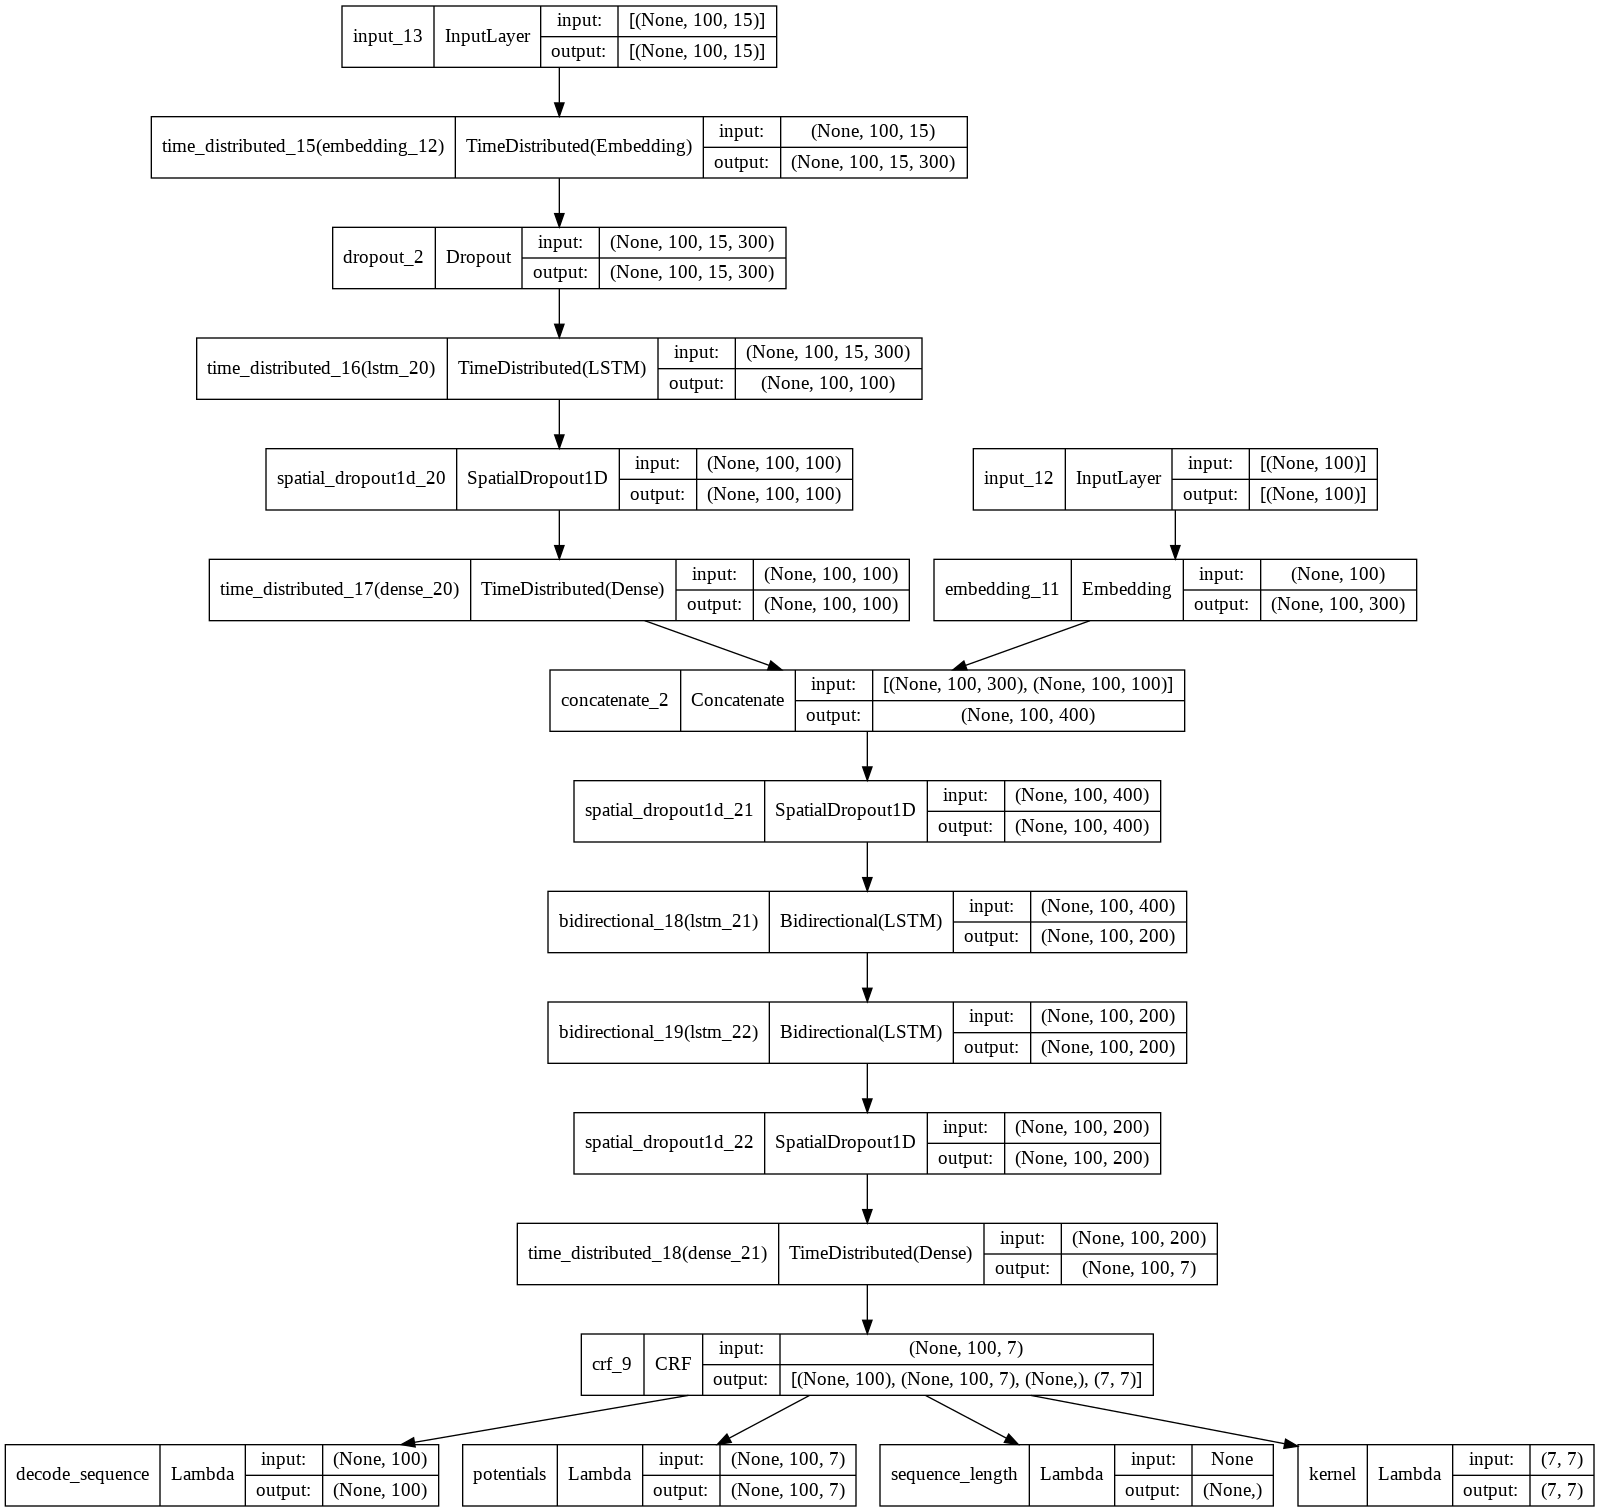

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 31s 635ms/step - decode_sequence_acc: 0.6945 - loss: 83.2966 - val_decode_sequence_acc: 0.7935 - val_loss: 41.8362
Epoch 2/30
26/26 [==============================] - 14s 535ms/step - decode_sequence_acc: 0.8175 - loss: 38.0063 - val_decode_sequence_acc: 0.8353 - val_loss: 27.2146
Epoch 3/30
26/26 [==============================] - 14s 532ms/step - decode_sequence_acc: 0.8581 - loss: 24.2308 - val_decode_sequence_acc: 0.8563 - val_loss: 19.6933
Epoch 4/30
26/26 [==============================] - 14s 525ms/step - decode_sequence_acc: 0.8703 - loss: 18.1336 - val_decode_sequence_acc: 0.8647 - val_loss: 16.6585
Epoch 5/30
26/26 [==============================] - 14s 526ms/step - decode_sequence_acc: 0.8767 - loss: 14.5784 - val_decode_sequence_acc: 0.8620 - val_loss: 13.7809
Epoch 6/30
26/26 [==============================] - 14s 527ms/step - decode_sequence_acc: 0.8790 - loss: 11.9725 - val_decode_sequence_acc: 0.8687 - val_loss: 13.596

### Đánh giá mô hình

In [ ]:
cprint_report()

              precision    recall  f1-score   support

    NEGATIVE     0.3142    0.3128    0.3135      1944
     NEUTRAL     0.2365    0.2141    0.2248       369
    POSITIVE     0.5388    0.5645    0.5513      3754

   micro avg     0.4524    0.4625    0.4574      6067
   macro avg     0.3632    0.3638    0.3632      6067
weighted avg     0.4484    0.4625    0.4552      6067



In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-POSITIVE
thấy                B-POSITIVE          	I-POSITIVE
mẫu                 I-POSITIVE          	I-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	B-POSITIVE
ứng                 I-POSITIVE          	I-POSITIVE
mượt                I-POSITIVE          	I-POSITIVE
được                B-POSITIVE          	I-POSITIVE
em                  I-POSITIVE          	I-POSITIVE
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I

## Sử dụng pre-trained wiki.vi.vec

### Xây dựng và huấn luyện mô hình BiLSTM-CRF

In [ ]:
model = cmodel_BiLSTM_CRF(embedding_matrix3)
model.summary()

Model: "crf_model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 100, 15)]    0           []                               
                                                                                                  
 time_distributed_19 (TimeDistr  (None, 100, 15, 300  102000     ['input_15[0][0]']               
 ibuted)                        )                                                                 
                                                                                                  
 dropout_3 (Dropout)            (None, 100, 15, 300  0           ['time_distributed_19[0][0]']    
                                )                                                                 
                                                                                       

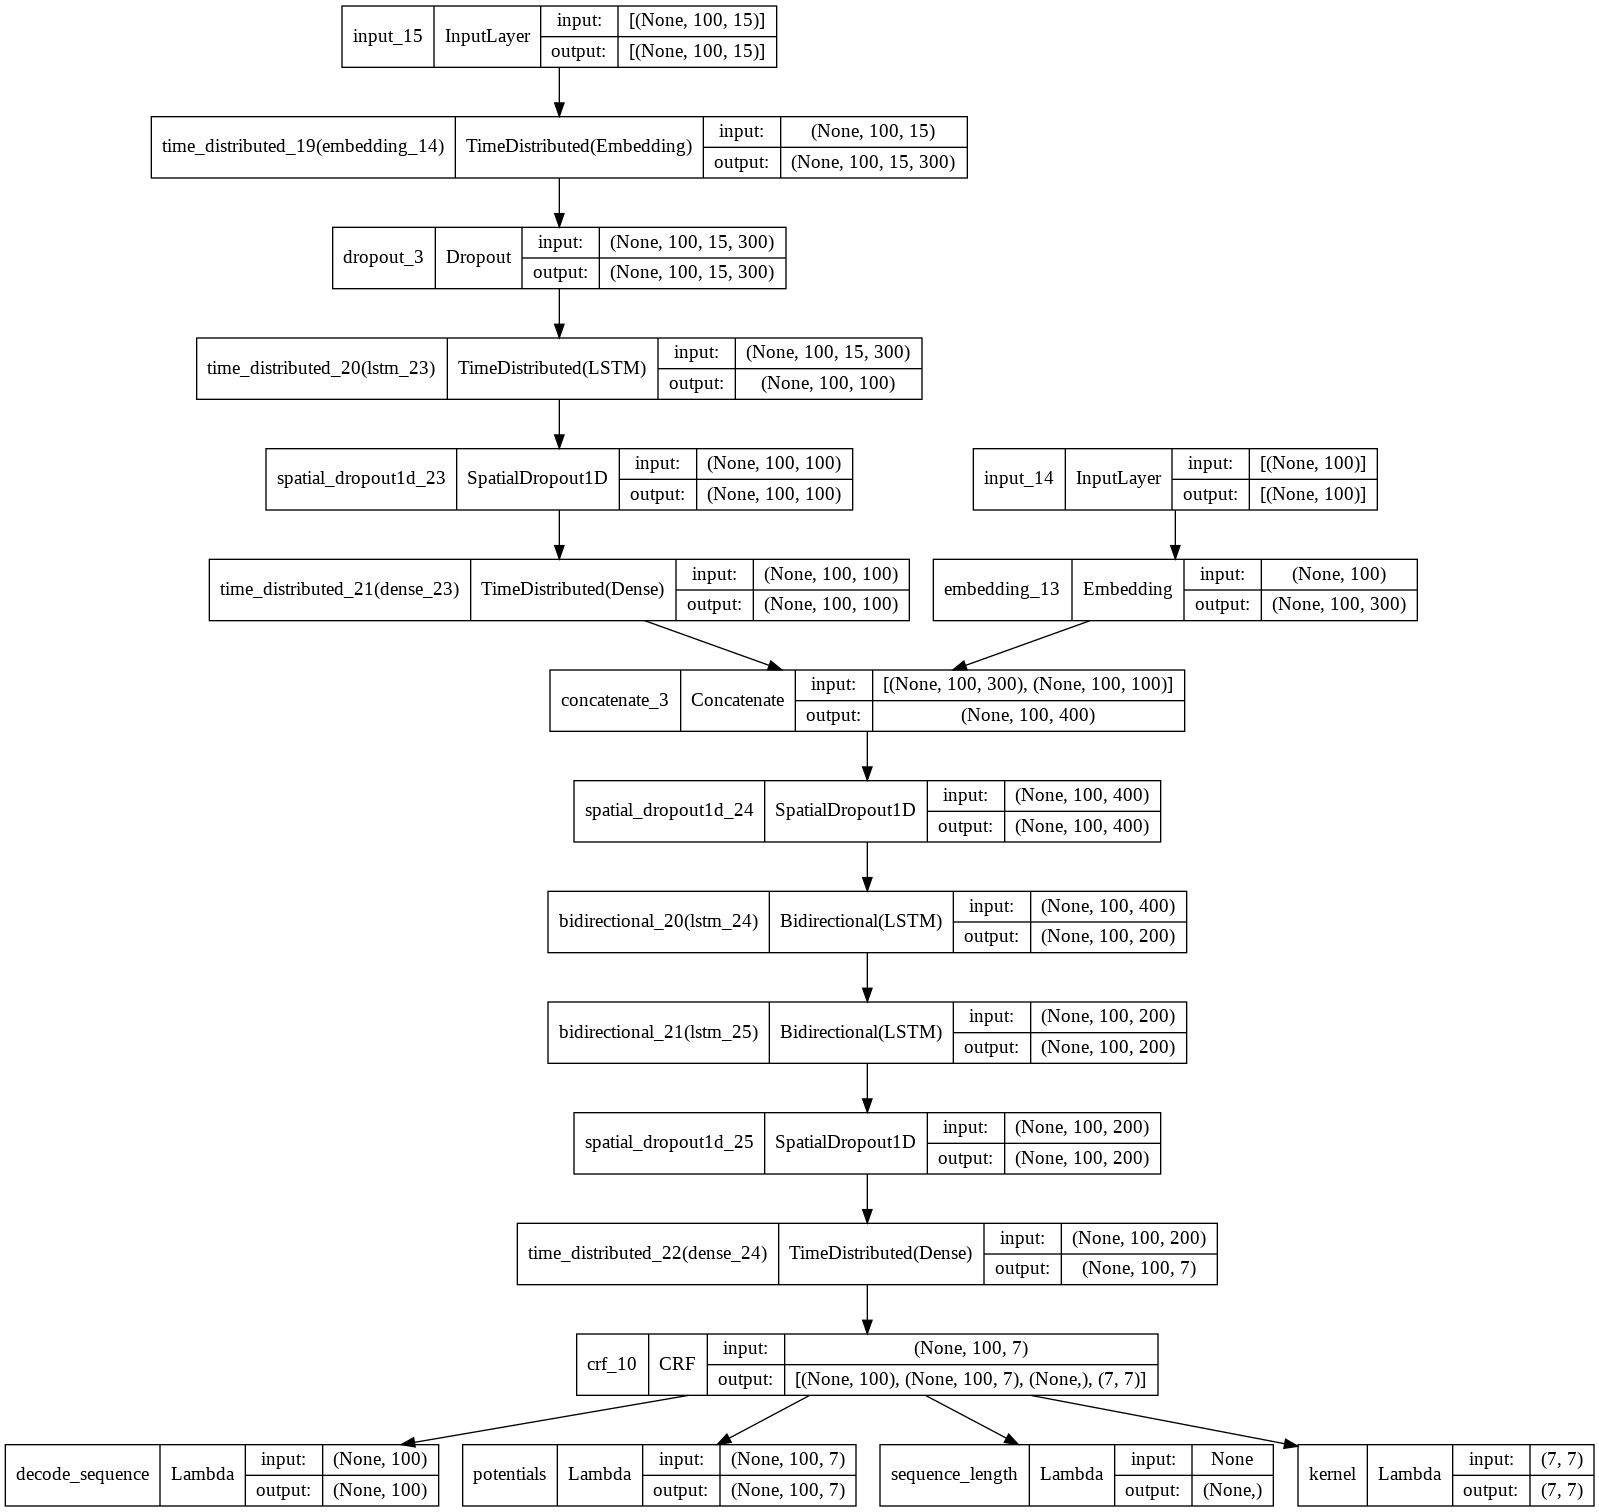

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x=[x_train, x_char_train],
    #x = x_char_train,
    y = y_train,
    validation_data=([x_dev, x_char_dev], y_dev),
    #validation_data=(x_char_dev, y_dev),
    batch_size= 300,
    epochs=30
)

Epoch 1/30
26/26 [==============================] - 32s 645ms/step - decode_sequence_acc: 0.7352 - loss: 69.6401 - val_decode_sequence_acc: 0.8093 - val_loss: 35.7691
Epoch 2/30
26/26 [==============================] - 13s 519ms/step - decode_sequence_acc: 0.8074 - loss: 28.8342 - val_decode_sequence_acc: 0.8189 - val_loss: 20.0388
Epoch 3/30
26/26 [==============================] - 14s 531ms/step - decode_sequence_acc: 0.8259 - loss: 19.3595 - val_decode_sequence_acc: 0.8211 - val_loss: 16.3230
Epoch 4/30
26/26 [==============================] - 14s 521ms/step - decode_sequence_acc: 0.8290 - loss: 14.8356 - val_decode_sequence_acc: 0.8376 - val_loss: 12.7199
Epoch 5/30
26/26 [==============================] - 14s 524ms/step - decode_sequence_acc: 0.8306 - loss: 12.3244 - val_decode_sequence_acc: 0.8372 - val_loss: 12.1874
Epoch 6/30
26/26 [==============================] - 13s 516ms/step - decode_sequence_acc: 0.8316 - loss: 10.4301 - val_decode_sequence_acc: 0.8330 - val_loss: 10.816

### Đánh giá mô hình

In [ ]:
cprint_report()

              precision    recall  f1-score   support

    NEGATIVE     0.3627    0.3328    0.3471      1944
     NEUTRAL     0.1750    0.2547    0.2075       369
    POSITIVE     0.5885    0.5719    0.5801      3754

   micro avg     0.4838    0.4760    0.4799      6067
   macro avg     0.3754    0.3865    0.3782      6067
weighted avg     0.4910    0.4760    0.4828      6067



In [ ]:
cpredict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	O
thấy                B-POSITIVE          	O
mẫu                 I-POSITIVE          	B-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	O
ứng                 I-POSITIVE          	O
mượt                I-POSITIVE          	O
được                B-POSITIVE          	O
em                  I-POSITIVE          	O
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I-POSITIVE          	I-POSITIVE
vấn                 I-POSITIVE  

# Chạy predict trên mô hình chỉ sử dụng pre-trained wiki.vi.vec

In [ ]:
predict(1)

Word                True                	 Pred

------------------------------
Mua                 O                   	O
cho                 O                   	O
mẹ                  O                   	O
sài                 O                   	B-POSITIVE
nên                 O                   	I-POSITIVE
củng                O                   	I-POSITIVE
không               O                   	I-POSITIVE
đòi                 O                   	I-POSITIVE
hỏi                 O                   	I-POSITIVE
gì                  O                   	I-POSITIVE
nhiều               O                   	I-POSITIVE
,                   O                   	O
máy                 B-POSITIVE          	B-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
camera              O                   	B-POSITIVE
siêu                O                   	I-POSITIVE
ảo                  O                   	I-POSITIVE
,                   O                   	O
thử                 B-POSITIVE

In [ ]:
predict(2)

Word                True                	 Pred

------------------------------
Máy                 B-POSITIVE          	B-POSITIVE
xài                 I-POSITIVE          	I-POSITIVE
tốt                 I-POSITIVE          	I-POSITIVE
,                   O                   	O
mượt                B-POSITIVE          	B-POSITIVE
,                   O                   	I-POSITIVE
sạc                 B-POSITIVE          	I-POSITIVE
rất                 I-POSITIVE          	I-POSITIVE
nhanh               I-POSITIVE          	I-POSITIVE
,                   O                   	O
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
,                   O                   	O
mình                O                   	B-POSITIVE
dùng                O                   	I-POSITIVE
tác                 O                   	I-POSITIVE
vụ                  O                   	I-POSITIVE
bình                O                   	I-POSITIVE
thường      

In [ ]:
predict(3)

Word                True                	 Pred

------------------------------
Mình                O                   	O
mới                 O                   	O
mua                 O                   	O
.                   O                   	O
mình                O                   	B-POSITIVE
thấy                B-POSITIVE          	I-POSITIVE
mẫu                 I-POSITIVE          	I-POSITIVE
đẹp                 I-POSITIVE          	I-POSITIVE
pin                 B-POSITIVE          	B-POSITIVE
trâu                I-POSITIVE          	I-POSITIVE
cảm                 B-POSITIVE          	B-POSITIVE
ứng                 I-POSITIVE          	I-POSITIVE
mượt                I-POSITIVE          	I-POSITIVE
được                B-POSITIVE          	I-POSITIVE
em                  I-POSITIVE          	I-POSITIVE
nhân                I-POSITIVE          	B-POSITIVE
viên                I-POSITIVE          	I-POSITIVE
ĐMX                 I-POSITIVE          	I-POSITIVE
tư                  I